In [1]:
import numpy as np
from jax import device_get
import datetime

def get_grid_structure(mesh):
    """Get the grid structure (nx, ny) of a refined mesh
    
    Args:
        mesh: The refined mesh
        
    Returns:
        tuple: (nx, ny) where nx is the number of points in x-direction
              and ny is the number of points in y-direction
    """
    # Get unique x and y coordinates
    unique_x = np.unique(mesh.p[0])
    unique_y = np.unique(mesh.p[1])
    
    # Count number of unique points in each direction
    nx = len(unique_x)
    ny = len(unique_y)
    
    return nx, ny, unique_x, unique_y

def deform_top_surface(mesh, top_deformations, ny, direction = 'top'):
    """Deform the mesh while preserving vertical ordering and fixing the bottom surface
    
    Args:
        mesh: The mesh to deform
        top_deformations: Array of target deformations for each point on the top surface
        amplitude: Maximum deformation amplitude
    """
    n_layers = ny

    
    # Apply deformation to all layers except the bottom
    for i in range(n_layers):  # Exclude the bottom layer
        # Find nodes in this layer
        layer_nodes = np.arange(i, len(mesh.p[0]), ny)
        # Calculate deformation for this layer
        # Amplitude decreases linearly from top to bottom
        # The bottom layer (i = n_layers-2) will have zero deformation
        if direction == 'top':
            layer_amplitude = i / (n_layers - 1)  # Adjusted for bottom layer exclusion
            deformation = top_deformations * layer_amplitude
        else:
            layer_amplitude = (n_layers - i) / (n_layers - 1)  # Adjusted for bottom layer exclusion
            deformation = top_deformations * layer_amplitude
        
        # Apply deformation
        mesh.p[1, layer_nodes] += deformation
        
        
def deform_left_surface(mesh, max_deformations, nx, direction = 'left'):
    """Deform the mesh while preserving vertical ordering and fixing the bottom surface
    
    Args:
        mesh: The mesh to deform
        top_deformations: Array of target deformations for each point on the top surface
        amplitude: Maximum deformation amplitude
    """
    n_layers = nx
    
    
    # Apply deformation to all layers except the bottom
    for i in range(n_layers):  # Exclude the bottom layer
        # Find nodes in this layer
        layer_nodes = np.arange(nx*i, nx*(i+1))
        # Calculate deformation for this layer
        # Amplitude decreases linearly from top to bottom
        # The bottom layer (i = n_layers-2) will have zero deformation
        if direction == 'right':
            layer_amplitude = i / (n_layers - 1)  # Adjusted for bottom layer exclusion
            deformation = max_deformations * layer_amplitude
        else:   
            layer_amplitude = (n_layers - i) / (n_layers - 1)  # Adjusted for bottom layer exclusion
            deformation = max_deformations * layer_amplitude
        
        # Apply deformation
        mesh.p[0, layer_nodes] += deformation     

import json

def plot_stress_displacement(x, scale_factor, m1, m2, basis1, basis2):
    # 변위 복원
    x_real = x / scale_factor

    m1defo = m1.translated(x_real[:basis1.N][basis1.nodal_dofs])
    m2defo = m2.translated(x_real[basis1.N:][basis2.nodal_dofs])
    
    basis1_defo = Basis(m1defo, ElementVector(ElementQuad1()))
    basis2_defo = Basis(m2defo, ElementVector(ElementQuad1()))

    # 변위 field
    u1 = basis1.interpolate(x_real[:basis1.N])
    u2 = basis2.interpolate(x_real[basis1.N:])

    u_mag1 = u1[1]
    u_mag2 = u2[1]

    # 변형률 field
    eps1 = 0.5 * (grad(u1) + transpose(grad(u1)) + mul(transpose(grad(u1)), grad(u1)))
    eps2 = 0.5 * (grad(u2) + transpose(grad(u2)) + mul(transpose(grad(u2)), grad(u2)))
    
    # 응력 field (선형 탄성)
    sig1 = 2 * mu * eps1 + lam * eye(trace(eps1), 2)
    sig2 = 2 * mu * eps2 + lam * eye(trace(eps2), 2)
    
    print(sig1.shape)
    # 원하는 응력 성분 예: sigma_yy
    sigma_yy1 = np.array(sig1[1, 1])
    sigma_yy2 = np.array(sig2[1, 1])

    # Element 0차 basis에 projection
    pbasis1 = basis1.with_element(ElementQuad0())
    pbasis2 = basis2.with_element(ElementQuad0())

    sigma_proj1 = pbasis1.project(sigma_yy1)
    sigma_proj2 = pbasis2.project(sigma_yy2)


    u_proj1 = pbasis1.project(np.array(u_mag1))
    u_proj2 = pbasis2.project(np.array(u_mag2))
    # 변형된 메쉬용 basis
    pbasis1_defo = Basis(m1.translated(x_real[:basis1.N][basis1.nodal_dofs]), ElementQuad0())
    pbasis2_defo = Basis(m2.translated(x_real[basis1.N:][basis2.nodal_dofs]), ElementQuad0())

    # 플롯
    with open('ax_config.json', 'r') as f:  
        ax_config = json.load(f)
    
    fig, ax = plt.subplots(ncols = 2, figsize=(16, 8))
    vmin = min(sigma_proj1.min(), sigma_proj2.min())
    vmax = max(sigma_proj1.max(), sigma_proj2.max())
    max_abs = max(abs(vmin), abs(vmax))
    pbasis1_defo.plot(sigma_proj1, ax=ax[0], cmap='coolwarm', shading='gouraud', vmin=-max_abs, vmax=max_abs)
    pbasis2_defo.plot(sigma_proj2, ax=ax[0], cmap='coolwarm', shading='gouraud', vmin=-max_abs, vmax=max_abs)
    
    if ax_config['mesh']:
        m1.translated(x_real[:basis1.N][basis1.nodal_dofs]).draw(ax=ax[0], boundary=True)
        m2.translated(x_real[basis1.N:][basis2.nodal_dofs]).draw(ax=ax[0], boundary=True)


    u_vmin = min(u_proj1.min(), u_proj2.min())
    u_vmax = max(u_proj1.max(), u_proj2.max())
    u_max_abs = max(abs(u_vmin), abs(u_vmax))
    pbasis1_defo.plot(u_proj1, ax=ax[1], cmap='coolwarm', shading='gouraud', vmin=-u_max_abs, vmax=u_max_abs)
    pbasis2_defo.plot(u_proj2, ax=ax[1], cmap='coolwarm', shading='gouraud', vmin=-u_max_abs, vmax=u_max_abs)
    
    if ax_config['mesh']:
        m1.translated(x_real[:basis1.N][basis1.nodal_dofs]).draw(ax=ax[1], boundary=True)
        m2.translated(x_real[basis1.N:][basis2.nodal_dofs]).draw(ax=ax[1], boundary=True)

    ax[0].set_title('Stress Field $\\sigma_{yy}$')
    ax[1].set_title('Displacement Field')
    

    
    ax[0].set_xlim(ax_config['xlim'][0], ax_config['xlim'][1])
    ax[0].set_ylim(ax_config['ylim'][0], ax_config['ylim'][1])
    ax[1].set_xlim(ax_config['xlim'][0], ax_config['xlim'][1])
    ax[1].set_ylim(ax_config['ylim'][0], ax_config['ylim'][1])


    plt.colorbar(ax[0].collections[0], ax=ax[0], orientation='vertical', label='$\\sigma_{yy}$ [N/um²]')
    plt.colorbar(ax[1].collections[0], ax=ax[1], orientation='vertical', label='Displacement [um]')
    plt.show()


In [67]:
def cp(E, h, topo, wavelength, Lres):
    d_mean =  topo
    k_mean = topo**2 * (2*np.pi)**4 / wavelength **4 * 1/2
    I = 1/12 * h**3
    
    return 0.5 * E * I * k_mean / d_mean
cp(E, thk, 3/2, 2*100000, 2*100000)

253.26363668840622

In [77]:
def criticalEnergy(E, h, wavelength, A):
    k = 2*np.pi / wavelength
    I = 1/12 * h**3
    return 1/2 * E * I * (A * k**2)**2


criticalEnergy(130e9, 40e-6, 2 * 100e-6, 3e-9 / 2)


0.0007597909100652188

elapsed time: 0.00e+00
||jac1||_F = 1.74e+14
||jac2||_F = 1.74e+14
||jacg||_F = 2.27e+16
모듈러스 129999999.99999999
밀도 2.2e-06
중력가속도 0.0098
접촉력 799.9999999999999
압력 25.32636366884062
중력 여부 False
접촉 여부 False
RHS norm by term:
J1 (body 1 internal) : 1.11e+07
J2 (body 2 internal) : 1.39e+07
traction (external)  : 0.00e+00
gravity1 (external)   : 0.00e+00
gravity2 (external)   : 0.00e+00
contact/adhesion gap   : 1.58e+14
Total RHS norm       : 1.58e+14
save params


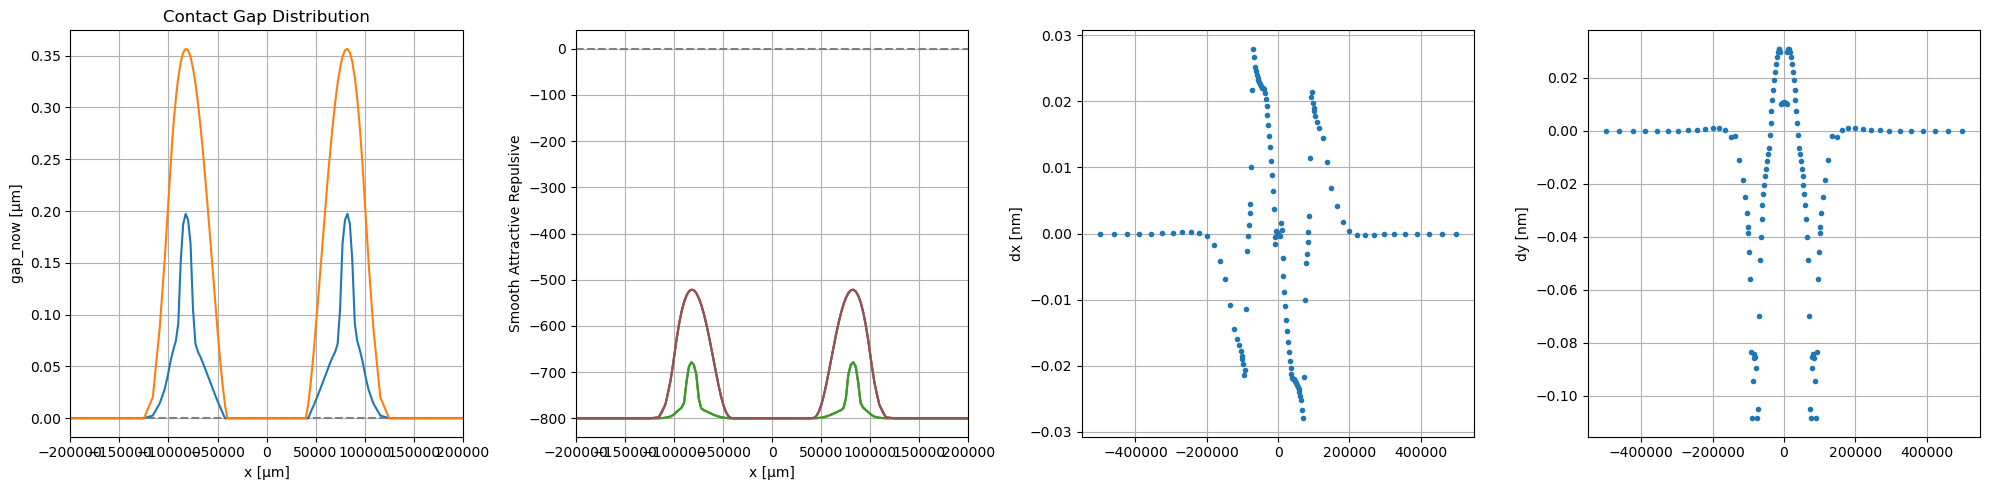

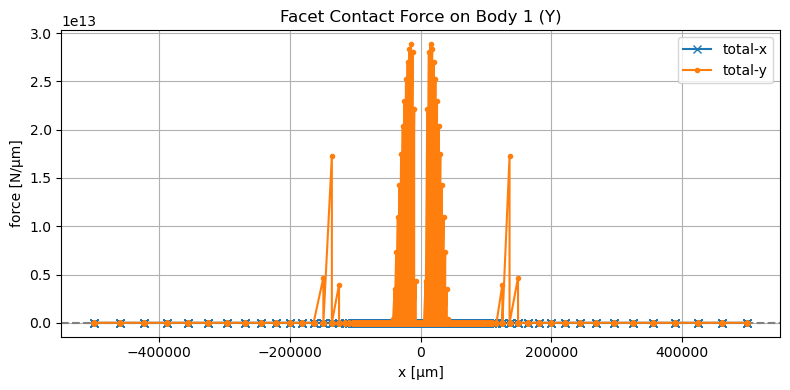

Iteration 2, Residual Norm: 3.63e+00, dx: -0.004291932325296292 0.05633429286117135 -0.1084631800255037
158359480348125.44
Left half: 0.0
Right half: 0.0
(2, 2, 5880, 9)


KeyboardInterrupt: 

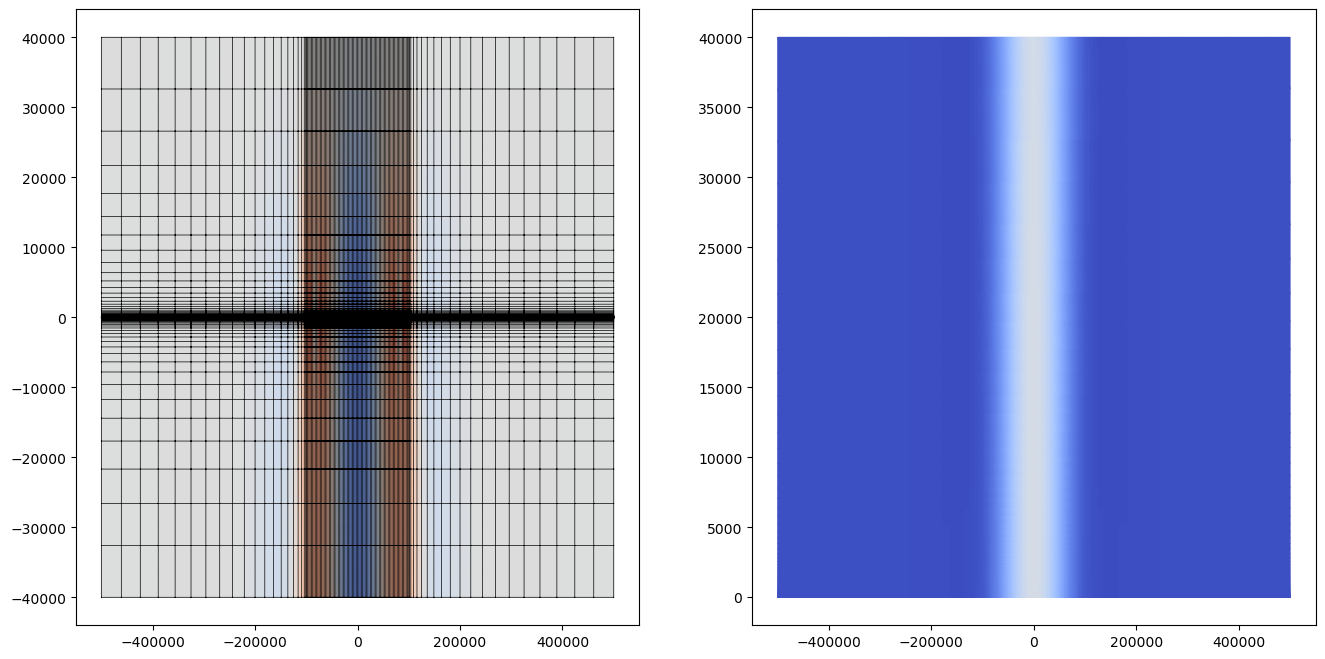

In [78]:
from skfem import *
from skfem.experimental.autodiff import *
from skfem.experimental.autodiff.helpers import *
from skfem.supermeshing import intersect, elementwise_quadrature
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from jax import device_get
from datetime import datetime
from scipy.sparse.linalg import norm
import os

start_path  = f'save/{datetime.now().strftime("%Y%m%d_%H%M%S")}'

load_file = 'save/sine_100_3_cp/120/u.npy'
mode = 'static'

def make_sparse_side(x0, x_end, n_pts, power=2.0):
    """
    x0      : 빽빽한 영역의 경계 (interest_xmin 또는 interest_xmax)
    x_end   : 도메인 외곽 (-width/2 또는 +width/2)
    n_pts   : 만들고 싶은 sparse 노드 개수 (x0 제외)
    power   : 간격 증폭 정도 (1보다 크면 OK)
    """
    t = np.linspace(0, 1, n_pts + 1)[1:]      # 0 은 빼서 x0 중복 제거
    if x_end < x0:                             # 왼쪽
        x = x0 - (x0 - x_end) * t**power
        return x[::-1]                         # 오름차순 정렬
    else:                                      # 오른쪽
        return x0 + (x_end - x0) * t**power

L0 = 1e-9 #1nm
m0 = 1e-18#1amu
t0 = 1e-6 #1um

wavelength0 = 100000 #100um

# 설정
wavelength = 100000 #100um
pressure =  1.3e5 / (m0/L0/t0**2) #1e5Pa
E = 130e9 / (m0/L0/t0**2)  # Young's modulus for SiO2 70GPa
gravity_acceleration = 9.8 / (L0/t0**2) #9.8m/s^2
rho = 2200 / (m0 / L0**3) #2200kg/m^3
E_adhesion_max = 0.0008 / (m0 / t0**2) #2J/m^2
nu = 0.27  # Poisson's ratio for SiO2


topo0 = 30e-10 / L0
topo = topo0 * wavelength / wavelength0
thk = 40e-6 / L0 #40um
width = 1e-3 / L0 #10mm
g0 = 0e-10 / L0 #0A
critical_gap = 4e-10/L0 #10A




apply_gravity = False
apply_traction = False

# Mesh 생성|
interest_xmin=-wavelength
interest_xmax=wavelength


nonuniform_coef = 10
x_dense        = np.linspace(interest_xmin, interest_xmax, 81)
x_sparse_left  = make_sparse_side(interest_xmin, -width/2, 20, power=2)
x_sparse_right = make_sparse_side(interest_xmax,  width/2, 20, power=2)

# 전체 격자
xs = np.concatenate([x_sparse_left, x_dense, x_sparse_right])

Ltot = xs.max() - xs.min()
Lres = Ltot - 2*wavelength

def cp(E, h, topo, wavelength, Lres):
    d_mean = topo
    k_mean = topo**2 * (2*np.pi)**4 / wavelength **4 * 1/2
    I = 1/12 * h**3
    
    return 0.5 * E * I * k_mean / d_mean

def criticalEnergy(E, h, wavelength, topo):
    k = 2*np.pi / wavelength
    return 1/2 * E * 1/12 * h**3 * (A * k**2)**2


critical_pressure = cp(E, thk, topo/2, 2*wavelength, Lres)

pressure = critical_pressure / 10


ny = 50
y_uniform = np.linspace(0, 1, ny)
y1 = topo#topo+0.1
y0 = topo+thk#thk+0.1
y_nonuniform1 = y1 + (y0 - y1) * (1 - np.exp(nonuniform_coef * (1 - y_uniform))) / (1 - np.exp(nonuniform_coef))
m1 = MeshQuad.init_tensor(xs, y_nonuniform1).with_defaults()

y1 = 0
y0 = -thk
y_nonuniform2 = y0 + (y1 - y0) * (1 - np.exp(-nonuniform_coef * y_uniform)) / (1 - np.exp(-nonuniform_coef))
m2 = MeshQuad.init_tensor(xs, y_nonuniform2).with_defaults()

# 요철 변형
nx, ny, xs_grid, ys_grid = get_grid_structure(m1)
base_topo = topo/2 * np.cos(np.pi + np.pi * xs_grid / wavelength) + topo/2
base_topo[(xs_grid < -wavelength) | (xs_grid > wavelength)] = 0#+topo
#deform_top_surface(m1, base_topo, ny, direction='bottom')

nx, ny, xs_grid, ys_grid = get_grid_structure(m2)
base_topo = topo/2 * np.cos(np.pi * xs_grid / wavelength) + topo/2
base_topo[(xs_grid < -wavelength) | (xs_grid > wavelength)] = 0#-topo
deform_top_surface(m2, base_topo, ny)

print("모듈러스", E)
print("밀도", rho)
print("중력가속도", gravity_acceleration)
print("접촉력", E_adhesion_max)
print("압력", pressure)
print("임계 압력", critical_pressure)


# 요소 설정
e1 = ElementVector(ElementQuad1())
e2 = ElementVector(ElementQuad1())
basis1 = Basis(m1, e1)
basis2 = Basis(m2, e2)
fbasis_load = FacetBasis(m1, e1, facets=m1.boundaries['top'])

# contact facet 추출 및 정렬
bottoms_m1 = np.array(sorted(list(set(list(m1.facets[0, m1.boundaries['bottom']]) + list(m1.facets[1, m1.boundaries['bottom']])))))
m1_bottom_points = m1.p[:, bottoms_m1]
x_m1 = m1_bottom_points[0, :]
y_m1 = m1_bottom_points[1, :]
order_m1 = np.argsort(x_m1)
x_m1 = x_m1[order_m1]
y_m1 = y_m1[order_m1]

tops_m2 = np.array(sorted(list(set(list(m2.facets[0, m2.boundaries['top']]) + list(m2.facets[1, m2.boundaries['top']])))))
m2_top_points = m2.p[:, tops_m2]
x_m2 = m2_top_points[0, :]
y_m2 = m2_top_points[1, :]
order_m2 = np.argsort(x_m2)
x_m2 = x_m2[order_m2]
y_m2 = y_m2[order_m2]

m1_bottom_interp = interp1d(x_m1, y_m1, bounds_error=False, fill_value="extrapolate")
m2_top_interp = interp1d(x_m2, y_m2, bounds_error=False, fill_value="extrapolate")


if not load_file is None:
    import os
    if load_file == 'last':
        load_file = 'x/'+os.listdir('x/')[-1]
    print('load ', load_file)
    x = np.load(load_file)
else:
    x = np.zeros(basis1.N + basis2.N)

# Lamé 상수
lam = (E * nu) / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))

@NonlinearForm(hessian=True)
def J1(u, w):
    eps = 0.5 * (grad(u) + transpose(grad(u)) + mul(transpose(grad(u)), grad(u)))
    sig = 2 * mu * eps + lam * eye(trace(eps), 2)
    return 0.5 * ddot(sig, eps)

@NonlinearForm(hessian=True)
def J2(u, w):
    eps = 0.5 * (grad(u) + transpose(grad(u)) + mul(transpose(grad(u)), grad(u)))
    sig = 2 * mu * eps + lam * eye(trace(eps), 2)
    return 0.5 * ddot(sig, eps)

@LinearForm
def gravity(v, w):
    return -gravity_acceleration * rho * v[1]

@LinearForm
def traction(v, w):
    return -pressure * v[1]


def smooth_attractive_repulsive(g, E0=2e-6, g0=0.4, a = 10):
    # Morse-type, centered at g0
    energy = E0 * (jnp.exp(-2 * a * (g-g0)) - 2 * jnp.exp(-a * (g-g0)))
    g_cut = g0 + jnp.log(2)/a
    F_cut = E0 * (2 * a * jnp.exp(-2 * a * (g_cut - g0)) - 2 * a * jnp.exp(-a * (g_cut - g0)))
    E_cut = E0 * (jnp.exp(-2 * a * (g_cut - g0)) - 2 * jnp.exp(-a * (g_cut - g0)))
    #return jnp.where(g < (g0 + jnp.log(2)/a), energy , jnp.minimum(E_cut - F_cut * (g - g_cut), 0) )
    return jnp.where(g < g_cut, energy , jax.lax.stop_gradient(energy))

def simple_exp_potential(g, E0=2e-6, a=10):
    return -E0 * jnp.exp(-a * g)

def contact_force(y):
    return smooth_attractive_repulsive(y,  E0 = E_adhesion_max, g0 = g0, a = 1/critical_gap) + jnp.where(y <= 0, max(pressure*1000, E * 1000, E_adhesion_max * 1000) * y**2, 0)
    #return simple_exp_potential(y, E0 = E_adhesion_max, a = 1/critical_gap) + jnp.where(y <= 0, max(pressure*1000, E * 1000, E_adhesion_max * 1000) * y**2, 0)

@NonlinearForm(hessian=True)
def g(u1, u2, w):
    xloc = w.x[0]
    y1_bottom = m1_bottom_interp(xloc)
    y2_top = m2_top_interp(xloc)
    local_gap = y1_bottom - y2_top
    gap_now = local_gap + u1[1] - u2[1]
    return contact_force(gap_now)

@BilinearForm
def mass(u, v, w):
    return rho * dot(u, v)

M1 = asm(mass, basis1)
M2 = asm(mass, basis2)
M = bmat([[M1, None], [None, M2]])

# 시간 적분 파라미터
dt = 1/100 # 시간 간격 [t0]
beta = 0.25
gamma = 0.5

elapsed_time = 0

x0 = x
# 초기 상태
v = np.zeros_like(x)
a = np.zeros_like(x)
dx = np.zeros_like(x)

for itr in range(1000):
    # 예측 단계
    dtp = dt
    pre_dx = np.zeros_like(x)
    if mode == 'dynamic':
        pre_dx = (dtp * v + 0.5 * dtp**2 * (1-2*beta) * a)
        
        while np.abs(pre_dx).max() > 0.5:
            dtp *= 0.5
            pre_dx = (dtp * v + 0.5 * dtp**2 * (1-2*beta) * a)
    
    x_pred = x + pre_dx * float(mode == 'dynamic')
    v_pred = v + (dtp * (1-gamma) * a) * float(mode == 'dynamic')

    x1_pred = x_pred[:basis1.N]
    x2_pred = x_pred[basis1.N:]

    m1defo = m1.translated(x1_pred[basis1.nodal_dofs])
    m2defo = m2.translated(x2_pred[basis2.nodal_dofs])

    m1t, orig1 = m1defo.trace('bottom', mtype=MeshLine, project=lambda p: np.array(p[0]))
    m2t, orig2 = m2defo.trace('top', mtype=MeshLine, project=lambda p: np.array(p[0]))

    # 공통 xmin, xmax 계산
    xmin = min(m1t.p[0].min(), m2t.p[0].min())
    xmax = max(m1t.p[0].max(), m2t.p[0].max())

    m1t.p[0][-1] = xmax
    m2t.p[0][-1] = xmax
    m1t.p[0][0] = xmin
    m2t.p[0][0] = xmin
    
    m12, t1, t2 = intersect(m1t, m2t)

    fbasis1 = FacetBasis(m1, e1, quadrature=elementwise_quadrature(m1t, m12, t1), facets=orig1[t1])
    fbasis2 = FacetBasis(m2, e2, quadrature=elementwise_quadrature(m2t, m12, t2), facets=orig2[t2])
    fbasis = fbasis1 * fbasis2

    res_dict = {}

    jac1, rhs1 = J1.assemble(basis1, x=x1_pred)
    jac2, rhs2 = J2.assemble(basis2, x=x2_pred)
    jacg, rhsg = g.assemble(fbasis, x=x_pred)
    res_dict['rhs1'] = rhs1.copy()
    res_dict['rhs2'] = rhs2.copy()
    res_dict['contact'] = rhsg
    
    if apply_gravity:
        f_gravity1 = gravity.assemble(basis1)
        f_gravity2 = gravity.assemble(basis2)
    else:
        f_gravity1 = np.zeros(basis1.N)
        f_gravity2 = np.zeros(basis2.N)
    
    if apply_traction:
        f_trac = traction.assemble(fbasis_load)
    else:
        f_trac = np.zeros(fbasis_load.N)
    

    res_dict['f_trac'] = f_trac.copy()
    res_dict['f_gravity1'] = f_gravity1.copy()
    res_dict['f_gravity2'] = f_gravity2.copy()
    
    rhs1 = rhs1 + f_trac + f_gravity1
    rhs2 = rhs2 + f_gravity2
    
    jac = bmat([[jac1, None], [None, jac2]])
    rhs = np.concatenate((rhs1, rhs2))

    jac += jacg
    rhs += rhsg
    
    dofs_b2_bottom = basis2.get_dofs({'bottom'})
    dofs_b2_bottom_y = (dofs_b2_bottom.all() + basis1.N)[1::2]  # y only

    #body1 중앙점 x 방향 고정
    dof_fix_b1_x = basis1.get_dofs({'bottom'}).all()[::2][len(xs)//2 : len(xs)//2 + 1]  # x 자유도 한 개
    
    #body2 중앙점 x 방향 고정
    dof_fix_b2_x = basis1.N + basis2.get_dofs({'top'}).all()[::2][len(xs)//2 : len(xs)//2 + 1]  # x 자유도 한 개

    D = np.unique(np.concatenate([
        dofs_b2_bottom_y,
        dof_fix_b1_x,
        dof_fix_b2_x,
    ]))


    if mode == 'dynamic':
        # 시스템 구성
        C = 1e3 * M + 1e-3 * jac
        effective_rhs = rhs - C @ v_pred - jac @ x_pred
        effective_matrix = M + gamma * dtp * C + beta * dtp**2 * jac
        a = solve(*enforce(effective_matrix, effective_rhs, D=D))
    
        dx = a * beta * dtp**2
        while np.abs(dx).max() > 0.5:
            dtp *= 0.5
            dx = a * beta * dtp**2
            
        x = x_pred + dx
        v = v_pred + gamma * dtp * a
        elapsed_time += dtp
    
    else:
        dx = solve(*enforce(jac, rhs, D=D))
        clip_mode = 'max'
        learning_config = json.load(open('learning_config.json'))
        lr = learning_config['lr']
        clip_x = 1
        if clip_mode == 'norm':
            dx_damped =  dx / max(1, np.linalg.norm(dx)) * lr
        elif clip_mode == 'max':
            dx_damped = dx / max(1, np.max(np.abs(dx)) / clip_x ) * lr
        x = x_pred + dx_damped

    x1 = x[:basis1.N]
    x2 = x[basis1.N:]
    
    #sava x with time
    np.save(f'x/x_values_{datetime.now().strftime("%Y%m%d_%H%M%S")}.npy', x)
    # 플롯
    from IPython.display import clear_output

    clear_output(wait=True)

    norm1 = norm(jac1)
    norm2 = norm(jac2)
    normg = norm(jacg)

    print(f"elapsed time: {elapsed_time:.2e}")
    print(f"||jac1||_F = {norm1:.2e}")
    print(f"||jac2||_F = {norm2:.2e}")
    print(f"||jacg||_F = {normg:.2e}")

    # 각 항의 크기 확인   
    print("모듈러스", E)
    print("밀도", rho)
    print("중력가속도", gravity_acceleration)
    print("접촉력", E_adhesion_max)
    print("압력", pressure)
    print("중력 여부", apply_gravity)
    print("접촉 여부", apply_traction)
    print("RHS norm by term:")
    print(f"J1 (body 1 internal) : {np.linalg.norm(res_dict['rhs1']):.2e}")
    print(f"J2 (body 2 internal) : {np.linalg.norm(res_dict['rhs2']):.2e}")
    print(f"traction (external)  : {np.linalg.norm(res_dict['f_trac']):.2e}")
    print(f"gravity1 (external)   : {np.linalg.norm(res_dict['f_gravity1']):.2e}")
    print(f"gravity2 (external)   : {np.linalg.norm(res_dict['f_gravity2']):.2e}")
    print(f"contact/adhesion gap   : {np.linalg.norm(res_dict['contact']):.2e}")
    rhs_total = np.concatenate([rhs1 + f_trac, rhs2]) + rhsg
    print(f"Total RHS norm       : {np.linalg.norm(rhs_total):.2e}")
    print("save params")
    
    path = f'{start_path}/{itr}/'

    os.makedirs(path, exist_ok=True)

    np.save(path+'xs.npy', xs)
    np.save(path+'y_nonuniform1.npy', y_nonuniform1)
    np.save(path+'y_nonuniform2.npy', y_nonuniform2)
    np.save(path+'u.npy', x)

    params = {'L0': L0,
            'm0': m0,
            't0': t0,
            'E': E,
            'nu': nu,
            'rho': rho,
            'gravity_acceleration': gravity_acceleration,
            'pressure': pressure,
            'E_adhesion_max': E_adhesion_max,
            'g0': g0,
            'width': width,
            'topo': topo,
            'thk': thk,
            "wavelength": wavelength,
            'apply_gravity': apply_gravity,
            'apply_traction': apply_traction}


    json.dump(params, open(path+'params.json', 'w'))
    
    
    def plot_gap(x, ax):
        x1 = x[:basis1.N]
        x2 = x[basis1.N:]
        # JAX -> NumPy 안전하게 추출
        u1 = device_get(fbasis1.interpolate(x1))
        u2 = device_get(fbasis2.interpolate(x2))
        xlocs = fbasis1.global_coordinates()[0]
        # 보간을 위한 NumPy 변환
        x_np = np.array(xlocs)
        y1 = m1_bottom_interp(x_np)
        y2 = m2_top_interp(x_np)
        local_gap = y1 - y2

        # 최종 gap 계산 (NumPy-safe)
        gap_now = local_gap + u1[1] - u2[1]
        
        ax.plot(xlocs.flatten(), gap_now.flatten())
        
        
    def plot_gap_energy(x, ax):
        x1 = x[:basis1.N]
        x2 = x[basis1.N:]
        # JAX -> NumPy 안전하게 추출
        u1 = device_get(fbasis1.interpolate(x1))
        u2 = device_get(fbasis2.interpolate(x2))
        xlocs = fbasis1.global_coordinates()[0]
        # 보간을 위한 NumPy 변환
        x_np = np.array(xlocs)
        y1 = m1_bottom_interp(x_np)
        y2 = m2_top_interp(x_np)
        local_gap = y1 - y2

        # 최종 gap 계산 (NumPy-safe)
        gap_now = local_gap + u1[1] - u2[1]
        
        ax.plot(xlocs, contact_force(gap_now))

    # 시각화
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))
    #READ AX CONFIG AND SET XLIM, YLIM
    ax_config = json.load(open('ax_config.json'))
    
    ax1.axhline(0, linestyle='--', color='gray')
    ax1.set_xlabel("x [μm]")
    ax1.set_ylabel("gap_now [μm]")
    ax1.set_title("Contact Gap Distribution")
    plot_gap(x, ax1)
    plot_gap(x0, ax1)
    ax1.set_xlim(*ax_config['xlim'])
    ax1.grid(True)


    ax2.axhline(0, linestyle='--', color='gray')
    ax2.set_xlabel("x [μm]")
    ax2.set_ylabel("Smooth Attractive Repulsive")
    plot_gap_energy(x, ax2)
    plot_gap_energy(x0, ax2)
    ax2.set_xlim(*ax_config['xlim'])
    ax2.grid(True)

    ax3.plot(m1.p[0, bottoms_m1], dx[0::2][bottoms_m1],'.')
    ax3.set_ylabel("dx [nm]")
    ax3.grid(True)
    
    ax4.plot(m1.p[0, bottoms_m1], dx[1::2][bottoms_m1],'.')
    ax4.set_ylabel("dy [nm]")
    ax4.grid(True)
    plt.tight_layout()
    plt.show()

    # 5. 시각화
    plt.figure(figsize=(8, 4))
    plt.axhline(0, linestyle='--', color='gray')


    x_data = fbasis1.doflocs[0]
    plt.plot(x_data[::2], rhsg[:fbasis1.N][::2],'x-', label='total-x')
    plt.plot(x_data[1::2], rhsg[:fbasis1.N][1::2],'.-', label='total-y')

    plt.xlabel("x [μm]")
    plt.ylabel("force [N/μm]")
    plt.title("Facet Contact Force on Body 1 (Y)")
    plt.legend()
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Iteration {itr}, Residual Norm: {np.linalg.norm(dx):.2e}, dx: {dx.mean()} {dx.max()} {dx.min()}")
    print(np.linalg.norm(rhs)) 
    print("Left half:", np.sum(f_trac[:len(f_trac)//2]))
    print("Right half:", np.sum(f_trac[len(f_trac)//2:]))
    plot_stress_displacement(x, 1, m1, m2, basis1, basis2)
    
    plt.pause(0.2)
    plt.close()
    




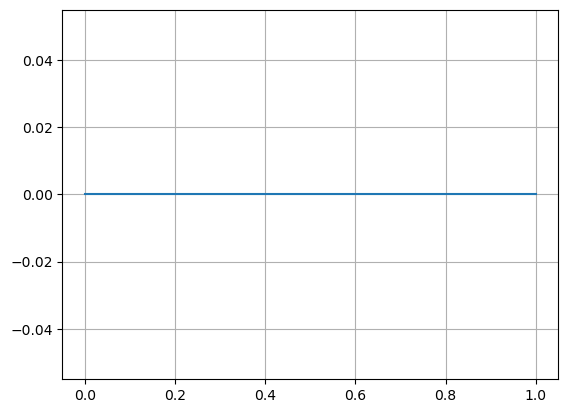

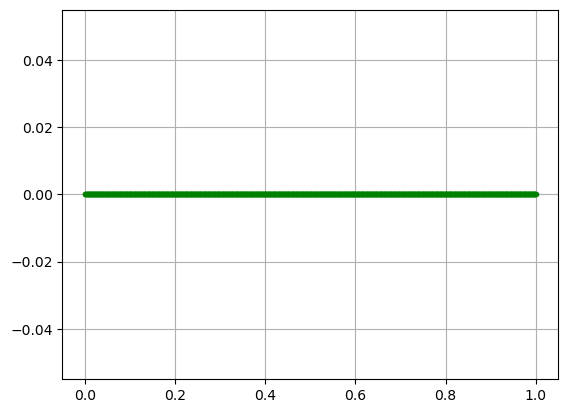

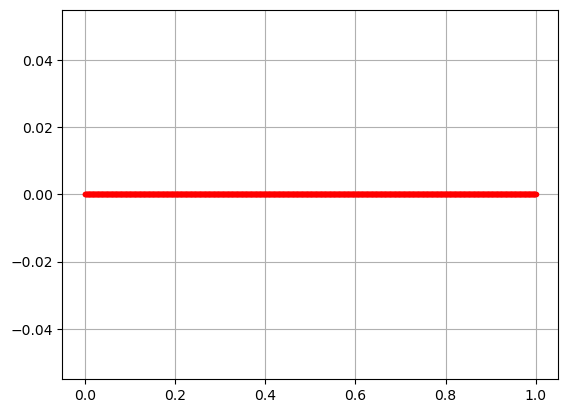

In [14]:

from jax import grad, vmap
xs = np.linspace(0.000001,1,1000)


rhs_fn = vmap(grad(contact_force))
jac_fn = vmap(grad(grad(contact_force)))
plt.plot(xs, contact_force(xs))
plt.grid()
plt.show()
plt.plot(xs,device_get(rhs_fn(xs)), 'g.')
plt.grid()
plt.show()
plt.plot(xs,device_get(jac_fn(xs)), 'r.')
plt.grid()
plt.show()

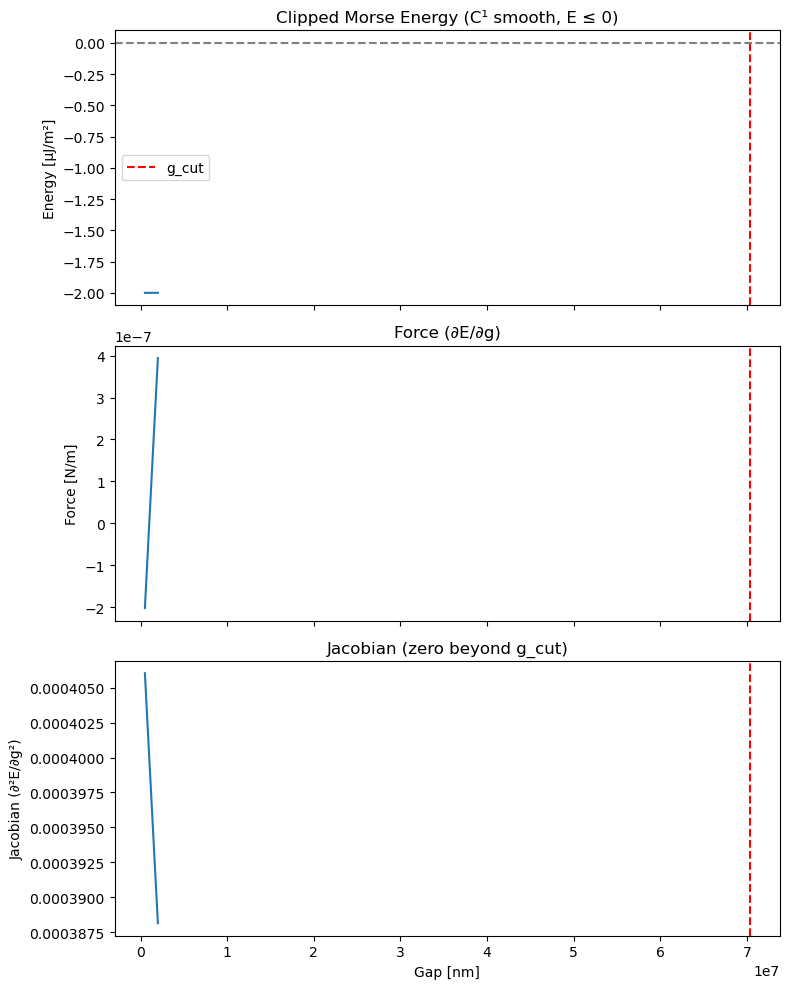

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import grad, hessian

# Parameters
E0 = 2e-6      # adhesion energy scale [J/nm^2]
g0 = 1.0e-3    # equilibrium gap [nm]
a = 10.0       # stiffness parameter [1/nm]
g_cut = g0 + jnp.log(2) / a  # cutoff gap where force flattens

# C¹-smooth clipped energy: Morse up to g_cut, linear afterwards
def morse_clipped_energy(g):
    Emorse = E0 * (jnp.exp(-2 * a * (g - g0)) - 2 * jnp.exp(-a * (g - g0)))
    Fmorse = E0 * (2 * a * jnp.exp(-2 * a * (g - g0)) - 2 * a * jnp.exp(-a * (g - g0)))

    E_cut = E0 * (jnp.exp(-2 * a * (g_cut - g0)) - 2 * jnp.exp(-a * (g_cut - g0)))
    F_cut = E0 * (2 * a * jnp.exp(-2 * a * (g_cut - g0)) - 2 * a * jnp.exp(-a * (g_cut - g0)))

    # Linear continuation of energy for g > g_cut
    E = jnp.where(g <= g_cut,
                  Emorse,
                  E_cut + F_cut * (g - g_cut))
    return E

# Derivatives
grad_E = grad(morse_clipped_energy)
hess_E = hessian(morse_clipped_energy)

# Evaluate and plot
g_vals = jnp.linspace(0.5e-3, 2.0e-3, 300)
E_vals = jnp.array([morse_clipped_energy(g) for g in g_vals])
F_vals = jnp.array([grad_E(g) for g in g_vals])
H_vals = jnp.array([hess_E(g) for g in g_vals])

fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
axs[0].plot(g_vals * 1e9, E_vals * 1e6)
axs[0].axvline(g_cut * 1e9, linestyle='--', color='red', label='g_cut')
axs[0].axhline(0, linestyle='--', color='gray')
axs[0].set_ylabel('Energy [μJ/m²]')
axs[0].set_title('Clipped Morse Energy (C¹ smooth, E ≤ 0)')
axs[0].legend()

axs[1].plot(g_vals * 1e9, F_vals)
axs[1].axvline(g_cut * 1e9, linestyle='--', color='red')
axs[1].set_ylabel('Force [N/m]')
axs[1].set_title('Force (∂E/∂g)')

axs[2].plot(g_vals * 1e9, H_vals)
axs[2].axvline(g_cut * 1e9, linestyle='--', color='red')
axs[2].set_ylabel('Jacobian (∂²E/∂g²)')
axs[2].set_xlabel('Gap [nm]')
axs[2].set_title('Jacobian (zero beyond g_cut)')

plt.tight_layout()
plt.show()


In [105]:
dof_fix_b2_x

array([36398])

In [98]:

bottoms_m1[len(xs)//2]

6000

In [21]:
import os
start_path  = f'save/{datetime.now().strftime("%Y%m%d_%H%M%S")}'
path = f'{start_path}/{itr}/'

os.makedirs(path, exist_ok=True)

np.save(path+'xs.npy', xs)
np.save(path+'y_nonuniform1.npy', y_nonuniform1)
np.save(path+'y_nonuniform2.npy', y_nonuniform2)
np.save(path+'u.npy', x)

params = {'L0': L0,
          'm0': m0,
          't0': t0,
          'E': E,
          'nu': nu,
          'rho': rho,
          'gravity_acceleration': gravity_acceleration,
          'pressure': pressure,
          'E_adhesion_max': E_adhesion_max,
          'g0': g0,
          'width': width,
          'topo': topo,
          'thk': thk,
          "wavelength": wavelength,
          'apply_gravity': apply_gravity,
          'apply_traction': apply_traction}


json.dump(params, open(path+'params.json', 'w'))






In [109]:
def g(u1, u2, w):
    xloc = w
    y1_bottom = m1_bottom_interp(xloc)
    y2_top = m2_top_interp(xloc)
    local_gap = y1_bottom - y2_top
    print(y1_bottom, y2_top, local_gap)
    gap_now = local_gap + u1[1] - u2[1]
    print(gap_now)

    return contact_force(gap_now)

0.1 -0.0846699606747484
총 자유도 수: 16
K의 랭크: 13
Nullspace 차원: 3
제약 개수: 3


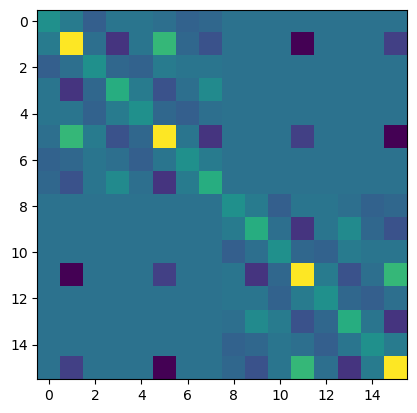

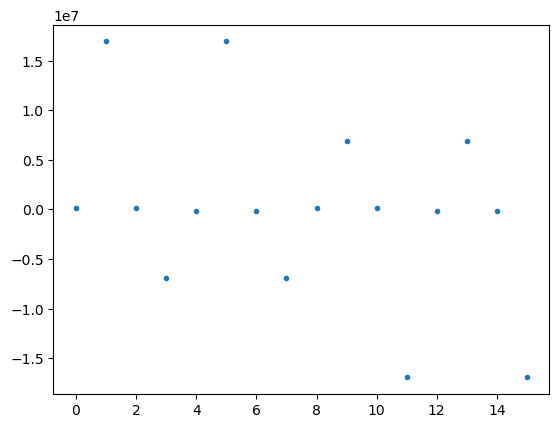

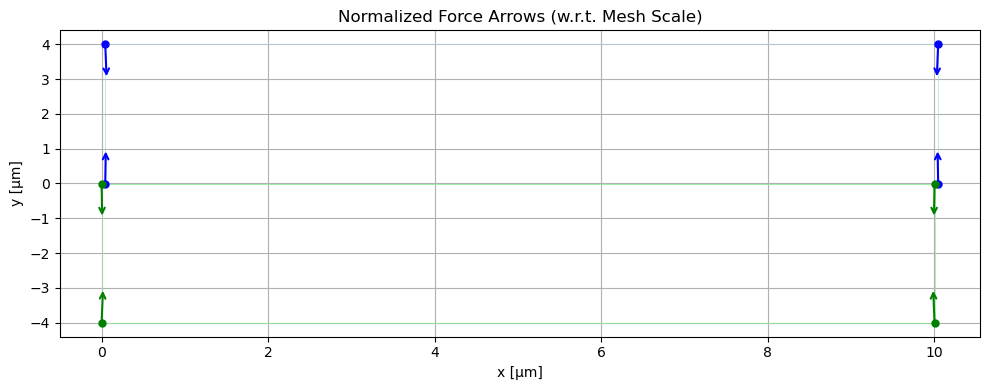

KeyboardInterrupt: 

In [68]:
from skfem import *
from skfem.experimental.autodiff import *
from skfem.experimental.autodiff.helpers import *
from skfem.supermeshing import intersect, elementwise_quadrature
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from jax import device_get
from datetime import datetime
from scipy.sparse.linalg import norm
import os
from IPython.display import clear_output

g0 = 0
# 전체 격자
xs = np.linspace(0,10,2)

ny = 2
y_uniform = np.linspace(0, 4, ny)
m1 = MeshQuad.init_tensor(xs, y_uniform).with_defaults()
m2 = MeshQuad.init_tensor(xs, y_uniform - 4).with_defaults()

# 요소 설정
e1 = ElementVector(ElementQuad1())
e2 = ElementVector(ElementQuad1())
basis1 = Basis(m1, e1)
basis2 = Basis(m2, e2)
fbasis_load = FacetBasis(m1, e1, facets=m1.boundaries['top'])


L0 = 1e-9 #1nm
m0 = 1e-18#1amu
t0 = 1e-6 #1um

# 설정
pressure =  1e5 / (m0/L0/t0**2) #1e5Pa
E = 70e9 / (m0/L0/t0**2)  # Young's modulus for SiO2 70GPa
gravity_acceleration = 9.8 / (L0/t0**2) #9.8m/s^2
rho = 2200 / (m0 / L0**3) #2200kg/m^3
E_adhesion_max = 5 / (m0 / t0**2) #2J/m^2
nu = 0.17

apply_gravity = False
apply_traction = True

# Lamé 상수
lam = (E * nu) / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))



@NonlinearForm(hessian=True)
def J1(u, w):
    eps = 0.5 * (grad(u) + transpose(grad(u)) + mul(transpose(grad(u)), grad(u)))
    sig = 2 * mu * eps + lam * eye(trace(eps), 2)
    return 0.5 * ddot(sig, eps)

@NonlinearForm(hessian=True)
def J2(u, w):
    eps = 0.5 * (grad(u) + transpose(grad(u)) + mul(transpose(grad(u)), grad(u)))
    sig = 2 * mu * eps + lam * eye(trace(eps), 2)
    return 0.5 * ddot(sig, eps)

@LinearForm
def gravity(v, w):
    return -gravity_acceleration * rho * v[1]

@LinearForm
def traction(v, w):
    return -pressure * v[1]

def smooth_attractive_repulsive(g, E0=2e-6, g0=0.4):
    # Morse-type, centered at g0
    a = 1
    eps = E0 * (jnp.exp(-2 * a * (g-g0)) - 2 * jnp.exp(-a * (g-g0)))
    return eps

def contact_energy(y):
    return smooth_attractive_repulsive(y, E_adhesion_max, g0) + jnp.where(y < 0, pressure* 100000 * y**2, 0)

@NonlinearForm(hessian=True)
def g(u1, u2, w):
    xloc = w.x[0]
    y1_bottom = m1_bottom_interp(xloc)
    y2_top = m2_top_interp(xloc)
    local_gap = y1_bottom - y2_top
    gap_now = local_gap + u1[1] - u2[1]
    
    return contact_energy(gap_now)

@BilinearForm
def mass(u, v, w):
    return rho * dot(u, v)

M1 = asm(mass, basis1)
M2 = asm(mass, basis2)
M = bmat([[M1, None], [None, M2]])

# contact facet 추출 및 정렬
bottoms_m1 = np.array(sorted(list(set(list(m1.facets[0, m1.boundaries['bottom']]) + list(m1.facets[1, m1.boundaries['bottom']])))))
m1_bottom_points = m1.p[:, bottoms_m1]
x_m1 = m1_bottom_points[0, :]
y_m1 = m1_bottom_points[1, :]
order_m1 = np.argsort(x_m1)
x_m1 = x_m1[order_m1]
y_m1 = y_m1[order_m1]

tops_m2 = np.array(sorted(list(set(list(m2.facets[0, m2.boundaries['top']]) + list(m2.facets[1, m2.boundaries['top']])))))
m2_top_points = m2.p[:, tops_m2]
x_m2 = m2_top_points[0, :]
y_m2 = m2_top_points[1, :]
order_m2 = np.argsort(x_m2)
x_m2 = x_m2[order_m2]
y_m2 = y_m2[order_m2]

m1_bottom_interp = interp1d(x_m1, y_m1, bounds_error=False, fill_value="extrapolate")
m2_top_interp = interp1d(x_m2, y_m2, bounds_error=False, fill_value="extrapolate")


x = np.zeros([basis1.N + basis2.N])
x1 = x[:basis1.N]
x2 = x[basis1.N:]

# 시간 적분 파라미터
dt = 0.01 # 시간 간격 [ns]
beta = 0.25
gamma = 0.5

# 초기 상태
v = np.zeros_like(x)
a = np.zeros_like(x)
dx = np.zeros_like(x)

for i in range(1000):
    # 예측 단계
    x_pred = x #+ dt * v
    v_pred = v
    # 2. 조립은 x_pred에서!
    x1_pred = x_pred[:basis1.N]
    x2_pred = x_pred[basis1.N:]
    
    m1defo = m1.translated(x1_pred[basis1.nodal_dofs])
    m2defo = m2.translated(x2_pred[basis2.nodal_dofs])
    
    m1t, orig1 = m1defo.trace('bottom', mtype=MeshLine, project=lambda p: np.array(p[0]))
    m2t, orig2 = m2defo.trace('top', mtype=MeshLine, project=lambda p: np.array(p[0]))

    
    # 공통 xmin, xmax 계산
    xmin = min(m1t.p[0].min(), m2t.p[0].min())
    xmax = max(m1t.p[0].max(), m2t.p[0].max())

    m1t.p[0][-1] = xmax
    m2t.p[0][-1] = xmax
    m1t.p[0][0] = xmin
    m2t.p[0][0] = xmin
    
    m12, t1, t2 = intersect(m1t, m2t)

    fbasis1 = FacetBasis(m1, e1, quadrature=elementwise_quadrature(m1t, m12, t1), facets=orig1[t1])
    fbasis2 = FacetBasis(m2, e2, quadrature=elementwise_quadrature(m2t, m12, t2), facets=orig2[t2])
    fbasis = fbasis1 * fbasis2
    
    jac1, rhs1 = J1.assemble(basis1, x=x1_pred)
    jac2, rhs2 = J2.assemble(basis2, x=x2_pred)
    jacg, rhsg = g.assemble(fbasis, x=x_pred)
    
    if apply_gravity:
        f_gravity1 = gravity.assemble(basis1, x=x1_pred)
        f_gravity2 = gravity.assemble(basis2, x=x2_pred)
    else:
        f_gravity1 = np.zeros(basis1.N)
        f_gravity2 = np.zeros(basis2.N)

    if apply_traction:
        f_trac = traction.assemble(fbasis_load, x =x1_pred)
    else:
        f_trac = np.zeros(fbasis_load.N)

    rhs1 = rhs1 + f_trac + f_gravity1
    rhs2 = rhs2 + f_gravity2
    
    jacg = jacg.tolil()
    for i in range(jacg.shape[0]):
        for j in jacg.rows[i]:
            val = jacg[i, j]
            if abs(val) < 0:
                jacg[i, j] = 0.0

    jacg = jacg.tocsr()
    
    jac = bmat([[jac1, None], [None, jac2]]) + jacg
    rhs = np.concatenate((rhs1, rhs2)) + rhsg

    dofs_b2_bottom = basis2.get_dofs({'bottom'})
    dofs_b2_bottom_y = (dofs_b2_bottom.all() + basis1.N)[1::2]  # y only

    # body2 왼쪽 하단 점에서 x, y 모두 고정
    dof_fix_b2_left = (basis2.get_dofs({'left'}).all()[:2] + basis1.N)

    # body1에서 x 방향 슬라이딩 제거 (중앙점 x 방향만)
    dof_fix_b1_x = basis1.get_dofs({'top'}).all()[::2][0:1]  # x 자유도 한 개

    D = np.unique(np.concatenate([
        dofs_b2_bottom_y,
        dof_fix_b2_left
    ]))
    
    """
    #1. dynamic

    # 시스템 구성
    effective_rhs = rhs - jac @ x_pred
    effective_matrix = M + gamma * dt * jac

    a = solve(*enforce(effective_matrix, effective_rhs, D=D))
    
    # 보정 단계
    dx = a * beta * dt**2
    while np.max(np.abs(dx)) > 0.01:
        dt *= 0.5
        dx = a * beta * dt**2

    x = x_pred + dx
    v = v_pred + gamma * dt * a
    """
    
    
    dx = solve(*enforce(jac, rhs, D=D))
    dx = dx / (np.abs(dx).max() / 0.1 )
    x = x_pred + dx
    
    x1 = x[:basis1.N]
    x2 = x[basis1.N:]

    #dx = solve(*enforce(jac, rhs, D=D))
    clear_output(wait=True)

    from numpy.linalg import matrix_rank

    # sparse → dense 변환 (작은 시스템일 때만 권장)
    K = jac
    K_dense = K.todense()
    rank = matrix_rank(K_dense)
    print(dx.max(), dx.min())
    print(f"총 자유도 수: {K.shape[0]}")
    print(f"K의 랭크: {rank}")
    print(f"Nullspace 차원: {K.shape[0] - rank}")
    print(f"제약 개수: {len(D)}")

    #visualize_fixed_dofs(m1,m2,basis1,basis2,D)
    #plt.plot(np.array((np.linalg.inv(effective_matrix.todense())@effective_rhs)[0,1::2])[0])
    plt.imshow(jac.todense())
    plt.show()
    
    plt.plot(rhs, '.')
    visualize_forces_normalized(m1.translated(x1[basis1.nodal_dofs]), m2.translated(x2[basis2.nodal_dofs]), basis1, basis2, rhs)
    #visualize_displacement(m1, m2, basis1, basis2, dx, scale = 1/np.abs(dx).max())
    """
    # 시각화
    fig, (ax3, ax4) = plt.subplots(1,2, figsize=(10, 5))
    #READ AX CONFIG AND SET XLIM, YLIM
    ax_config = json.load(open('ax_config.json'))

    ax3.plot(m1.p[0, bottoms_m1], dx[1::2][bottoms_m1],'.')
    ax3.set_ylabel("dy [nm]")
    ax3.grid(True)

    ax4.plot(m1.p[0, bottoms_m1], dx[0::2][bottoms_m1],'.')
    ax4.set_ylabel("dx [nm]")
    ax4.grid(True)


    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    x_data = fbasis1.doflocs[0]

    plt.plot(x_data[::2], rhs[:fbasis1.N][::2],'x-', label='total-x')
    plt.plot(x_data[1::2], rhs[:fbasis1.N][1::2],'.-', label='total-y')

    plt.xlabel("x [μm]")
    plt.ylabel("force [N/μm]")
    plt.title("Facet Contact Force on Body 1 (Y)")
    plt.legend()
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()
    """

In [51]:
rhs

array([ 3.23239489e-06,  3.22180977e+08,  2.92513182e-06, -4.97474774e+02,
       -2.92328732e-06,  3.22180456e+08, -3.23423939e-06, -4.97474774e+02,
       -3.61299744e-09, -6.84774062e-01,  7.73992412e-10, -3.22180979e+08,
        1.41867911e-09, -6.84773888e-01,  1.42032592e-09, -3.22180458e+08])

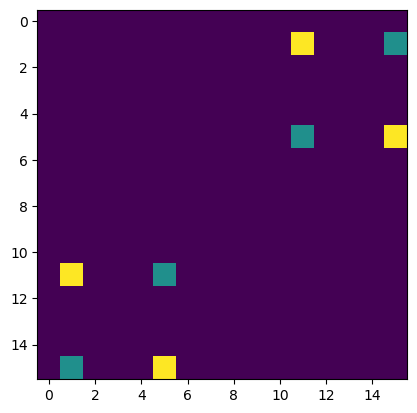

In [178]:
plt.imshow(jacg.todense())

In [156]:
(rhs - rhsg)[1::2], rhsg[1::2]

(array([-0.00012936,  0.00012936, -0.00012936,  0.00012936, -0.00012936,
         0.00012936, -0.00012936,  0.00012936]),
 array([-407.98174543,    0.        , -407.98174543,    0.        ,
           0.        ,  407.98174543,    0.        ,  407.98174543]))

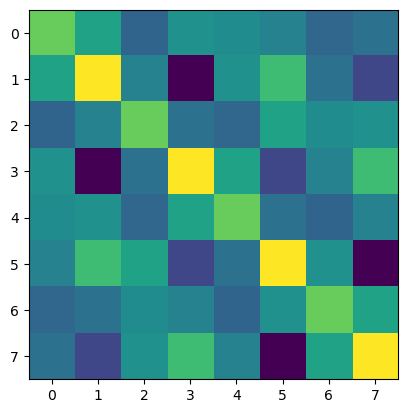

In [157]:
plt.imshow(jac1.todense())

In [19]:
from jax import grad, vmap


def smooth_attractive_repulsive(g, E0=2e-6, g0=2):
    # Morse-type, centered at g0
    a = 10
    eps = E0 * (jnp.exp(-2 * a * (g-g0)) - 2 * jnp.exp(-a * (g-g0)))
    return jnp.where(g < (g0 + jnp.log(2)/a), eps , jnp.lax.stop_gradient(eps))

def smooth_attractive_repulsive2(g, E0=2e-6, g0=2):
    # Morse-type, centered at g0
    a = 10
    eps = E0 * (jnp.exp(-2 * a * (g-g0)) - 2 * jnp.exp(-a * (g-g0)))
    return jnp.where(g < (g0 + jnp.log(2)/a), eps , -0.75 * E0)




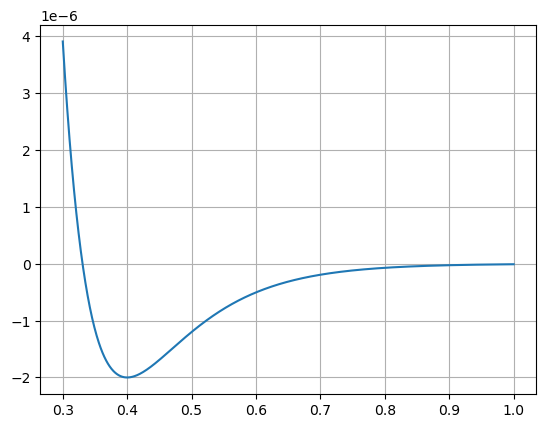

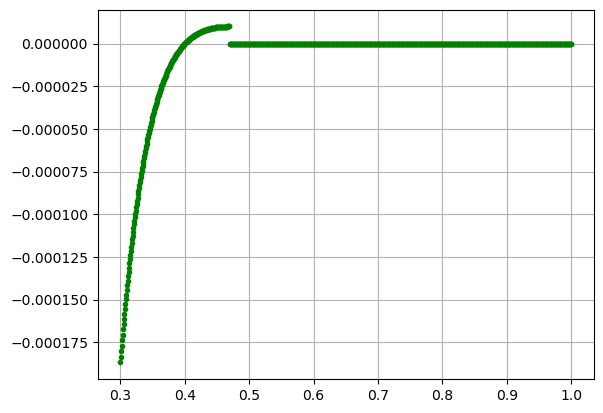

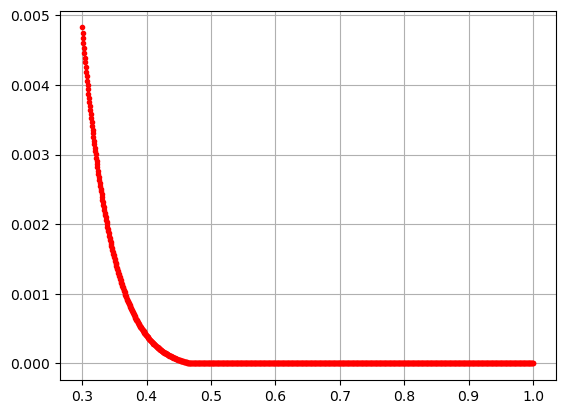

In [87]:
from jax import grad, vmap
xs = np.linspace(0.3,1,1000)

def smooth_attractive_repulsive(g, E0=2e-6, g0=0.4):
    # Morse-type, centered at g0
    a = 10
    eps = E0 * (jnp.exp(-2 * a * (g-g0)) - 2 * jnp.exp(-a * (g-g0)))
    return jnp.where(g < (g0 + jnp.log(2)/a), eps , jax.lax.stop_gradient(eps))

rhs_fn = vmap(grad(smooth_attractive_repulsive))
jac_fn = vmap(grad(grad(smooth_attractive_repulsive)))
plt.plot(xs, smooth_attractive_repulsive(xs))
plt.grid()
plt.show()
plt.plot(xs,device_get(rhs_fn(xs)), 'g.')
plt.grid()
plt.show()
plt.plot(xs,device_get(jac_fn(xs)), 'r.')
plt.grid()
plt.show()


In [184]:
rhsg

array([ 0.00000000e+00, -3.55888733e+08,  0.00000000e+00, ...,
        0.00000000e+00,  0.00000000e+00,  3.55889067e+08])

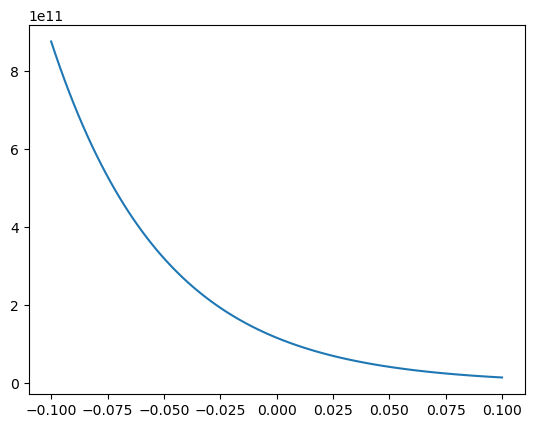

In [33]:

xs = np.linspace(-0.1,0.1,100)
plt.plot(xs,-device_get(force_fn(xs)))

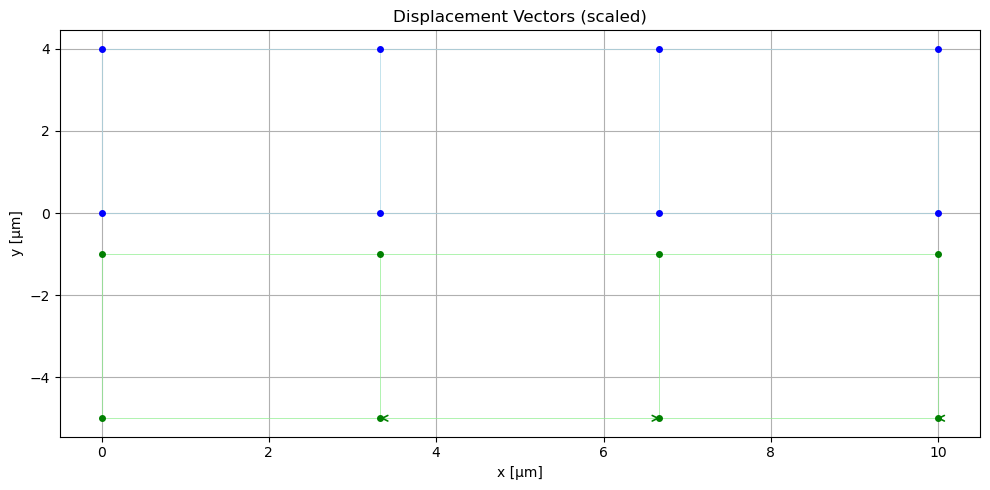

In [ ]:
def visualize_displacement(m1, m2, basis1, basis2, dx, scale=1e11):
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots(figsize=(10, 5))

    m1.draw(ax=ax, color='lightblue', edgecolor='gray', lw=0.5)
    m2.draw(ax=ax, color='lightgreen', edgecolor='gray', lw=0.5)

    def draw_arrows(mesh, u, color):
        p = mesh.p
        n_nodes = p.shape[1]

        ux = u[0::2][:n_nodes]
        uy = u[1::2][:n_nodes]
        for i in range(n_nodes):
            start = p[:, i]
            end = start + np.array([ux[i], uy[i]]) * scale

            # 원점: 현재 위치
            ax.plot(start[0], start[1], 'o', color=color, markersize=4)

            # 화살표: 변위
            ax.annotate("",
                        xy=end, xytext=start,
                        arrowprops=dict(arrowstyle="->", color=color, lw=1.2))

    draw_arrows(m1, dx[:basis1.N], 'blue')
    draw_arrows(m2, dx[basis1.N:], 'green')

    ax.set_title("Displacement Vectors (scaled)")
    ax.set_xlabel("x [μm]")
    ax.set_ylabel("y [μm]")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

visualize_displacement(m1, m2, basis1, basis2, dx)

In [3]:
import matplotlib.pyplot as plt


dofs_b2_bottom = basis2.get_dofs({'bottom'})
dofs_b2_bottom_y = (dofs_b2_bottom.all() + basis1.N)[1::2]  # y only

# body2 왼쪽 하단 점에서 x, y 모두 고정
dof_fix_b2_left = (basis2.get_dofs({'left'}).all()[:2] + basis1.N)

# body1에서 x 방향 슬라이딩 제거 (중앙점 x 방향만)
dof_fix_b1_x = basis1.get_dofs({'bottom'}).all()[::2][:1]  # x 자유도 한 개

D = np.unique(np.concatenate([
    dofs_b2_bottom_y,
    dof_fix_b2_left,
    dof_fix_b1_x
]))

def visualize_fixed_dofs(m1, m2, basis1, basis2, D):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(10, 4))

    m1.draw(ax=ax, color='lightblue', edgecolor='gray', lw=0.5)
    m2.draw(ax=ax, color='lightgreen', edgecolor='gray', lw=0.5)

    # 고정된 노드별 x/y 여부 저장
    from collections import defaultdict
    dof_map = defaultdict(lambda: {'x': False, 'y': False})

    for dof in D:
        if dof < basis1.N:
            node_idx = dof // 2
            dof_type = 'x' if dof % 2 == 0 else 'y'
            dof_map[('m1', node_idx)][dof_type] = True
        else:
            node_idx = (dof - basis1.N) // 2
            dof_type = 'x' if (dof - basis1.N) % 2 == 0 else 'y'
            dof_map[('m2', node_idx)][dof_type] = True

    # 색상별로 점을 분류
    color_points = {'red': [], 'blue': [], 'purple': []}

    for (mesh_id, node_idx), flags in dof_map.items():
        if mesh_id == 'm1':
            x, y = m1.p[:, node_idx]
        else:
            x, y = m2.p[:, node_idx]

        if flags['x'] and flags['y']:
            color_points['purple'].append((x, y))
        elif flags['x']:
            color_points['red'].append((x, y))
        elif flags['y']:
            color_points['blue'].append((x, y))

    # 점 그리기
    for color, points in color_points.items():
        if points:
            px, py = zip(*points)
            ax.plot(px, py, 'o', color=color, markersize=6, label=f'{color.capitalize()} ({"x/y" if color=="purple" else color[0]})')

    ax.set_title("Fixed DOF Locations (Color-Coded)")
    ax.set_xlabel("x [μm]")
    ax.set_ylabel("y [μm]")
    ax.axis("equal")
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
def visualize_forces_normalized(m1, m2, basis1, basis2, rhs, normalize=True, min_len=1):
    import matplotlib.pyplot as plt
    from numpy.linalg import norm

    fig, ax = plt.subplots(figsize=(10, 4))

    m1.draw(ax=ax, color='lightblue', edgecolor='gray', lw=0.5)
    m2.draw(ax=ax, color='lightgreen', edgecolor='gray', lw=0.5)

    def avg_edge_length(m):
        try:
            if m.edges is None:
                raise AttributeError
            diffs = m.p[:, m.edges[1]] - m.p[:, m.edges[0]]
            lengths = norm(diffs, axis=0)
            return np.mean(lengths)
        except AttributeError:
            # fallback: use bounding box diagonal / sqrt(#nodes)
            bbox_diag = norm(m.p.max(axis=1) - m.p.min(axis=1))
            return bbox_diag / np.sqrt(m.p.shape[1])

    scale_len = (avg_edge_length(m1) + avg_edge_length(m2)) / 2

    def draw_forces(p, fx, fy, color='blue'):
        for i in range(p.shape[1]):
            start = p[:, i]
            force_vec = np.array([fx[i], fy[i]])

            if normalize:
                magnitude = norm(force_vec)
                if magnitude == 0:
                    
                    continue
                direction = force_vec / magnitude
                display_len = min(magnitude * scale_len, min_len)
                arrow_vec = direction * display_len
            else:
                arrow_vec = force_vec * scale_len

            end = start + arrow_vec

            ax.plot(start[0], start[1], 'o', color=color, markersize=5)

            ax.annotate("",
                        xy=end, xytext=start,
                        arrowprops=dict(arrowstyle="->", color=color, lw=1.5))

    # Body 1
    p1 = m1.p
    fx1 = rhs[0::2][:p1.shape[1]]
    fy1 = rhs[1::2][:p1.shape[1]]
    draw_forces(p1, fx1, fy1, color='blue')

    # Body 2
    p2 = m2.p
    fx2 = rhs[basis1.N::2][:p2.shape[1]]
    fy2 = rhs[basis1.N+1::2][:p2.shape[1]]
    draw_forces(p2, fx2, fy2, color='green')

    ax.set_title("Normalized Force Arrows (w.r.t. Mesh Scale)")
    ax.set_xlabel("x [μm]")
    ax.set_ylabel("y [μm]")
    ax.grid(True)
    plt.tight_layout()
    plt.show()





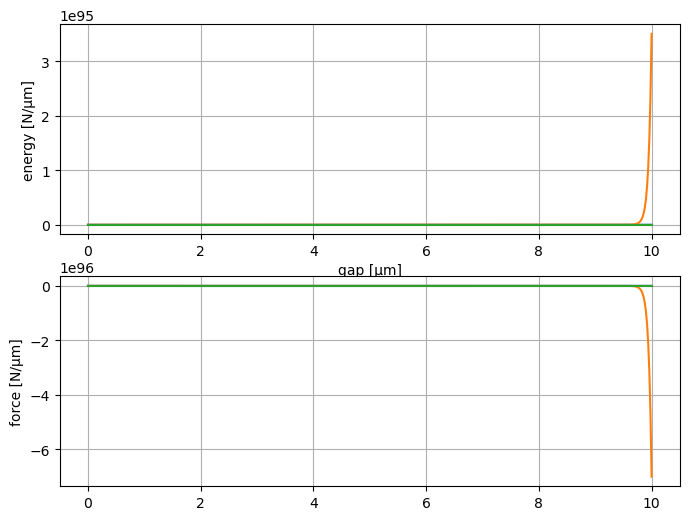

In [38]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import grad, vmap

def smooth_attractive_repulsive(g, E0=2e-6, g0=1e-3):
    # Morse-type, centered at g0
    a = 5
    return E0 * (jnp.exp(-2 * a * (g-g0)) - 2 * jnp.exp(-a * (g-g0)))


def contact_force(y):
    return smooth_attractive_repulsive(-y, 1, g0) + jnp.where(y < 0, 100 * y**2, 0)

gap_vals = jnp.linspace(0, 10, 500)

# 각 gap에 대해 개별적으로 미분
g0 = 0.5
from jax import grad, vmap
force_fn = vmap(grad(contact_force))
force_vals_1 = -force_fn(gap_vals)  # 음수 방향이 실제 접착력
energy_fn = vmap(contact_force)
energy_vals_1 = energy_fn(gap_vals)

def smooth_attractive_repulsive(g, E0=2e-6, g0=1e-3):
    # Morse-type, centered at g0
    a = 10
    return E0 * (jnp.exp(-2 * a * (g-g0)) - 2 * jnp.exp(-a * (g-g0)))

g0 = 1
force_fn = vmap(grad(contact_force))
force_vals_2 = -force_fn(gap_vals)  # 음수 방향이 실제 접착력
energy_fn = vmap(contact_force)
energy_vals_2 = energy_fn(gap_vals)

g0 = 0.5
force_fn = vmap(grad(contact_force))
force_vals_3 = -force_fn(gap_vals)  # 음수 방향이 실제 접착력
energy_fn = vmap(contact_force)
energy_vals_3 = energy_fn(gap_vals)


#plot energy @ ax1, force @ ax2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.plot(gap_vals, energy_vals_3)
ax1.plot(gap_vals, energy_vals_2)
ax1.plot(gap_vals, energy_vals_1)

ax2.plot(gap_vals, force_vals_3)
ax2.plot(gap_vals, force_vals_2)
ax2.plot(gap_vals, force_vals_1)

ax1.set_xlabel("gap [μm]")
ax1.set_ylabel("energy [N/μm]")
ax2.set_ylabel("force [N/μm]")
ax1.grid(True)
ax2.grid(True)

plt.show()

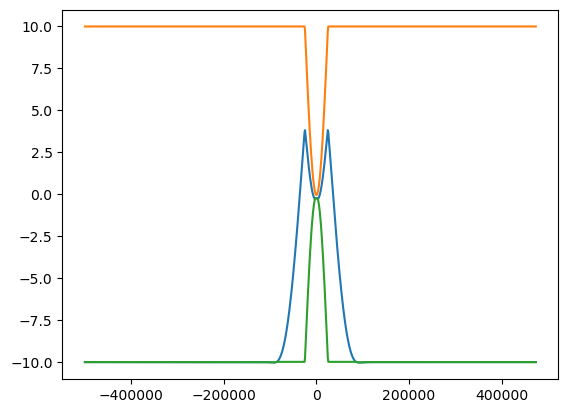

In [ ]:
plt.plot(*m1defo.p[:, m1defo.facets[:, m1defo.boundaries['bottom']][0]])
plt.plot(*m1.p[:, m1.facets[:, m1.boundaries['bottom']][0]])
plt.plot(*m2defo.p[:, m2defo.facets[:, m2defo.boundaries['top']][0]])

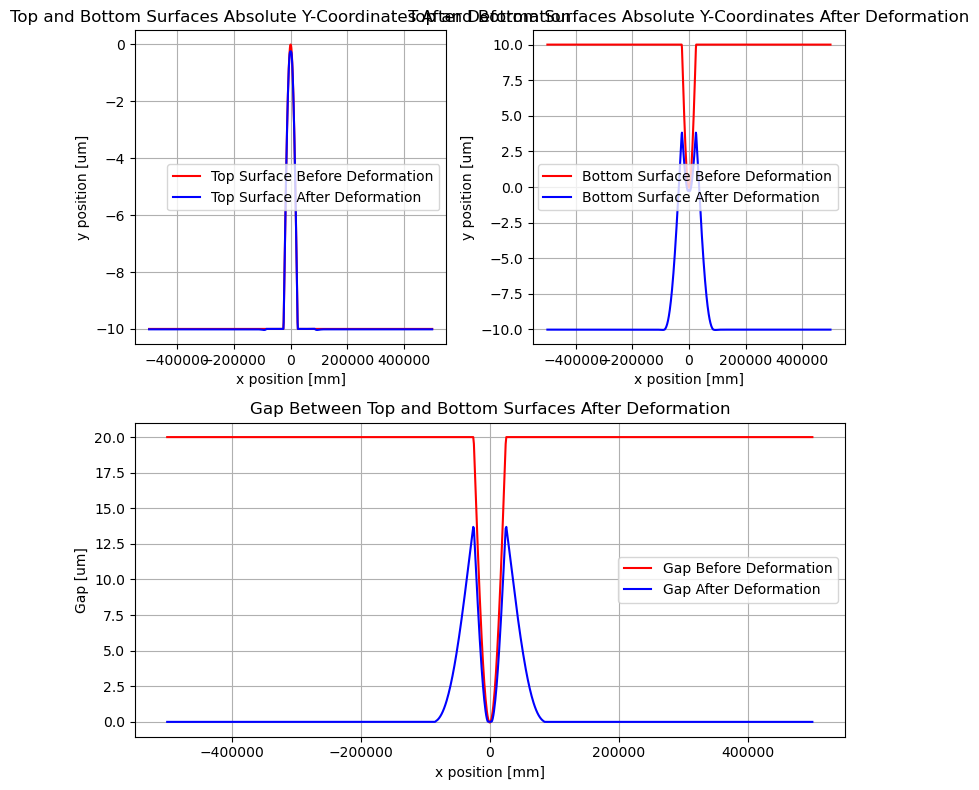

In [ ]:
# 1. 변위 복원
x_real = x / scale_factor

# 2. Basis 만들기 (변형 전 mesh 기준, 변위만 복원)
basis2 = Basis(m2, e2)

# 3. 변위 field
u2 = basis2.interpolate(x_real[basis1.N:])

# 4. top boundary facets
top_facets = m2.boundaries['top']

# 5. top boundary에 연결된 node 번호 추출
top_nodes = np.unique(m2.facets[:, top_facets])

# 6. bottom boundary facets for m1
bottom_facets_m1 = m1.boundaries['bottom']

# 7. bottom boundary에 연결된 node 번호 추출 for m1
bottom_nodes_m1 = np.unique(m1.facets[:, bottom_facets_m1])

# 6. top node들의 x좌표와 y좌표
x_top = m2.p[0, top_nodes]
y_top = m2.p[1, top_nodes]

# 7. 해당 node들의 변위 추출
# (ElementVector이니까 2배 인덱싱 필요)
u_y_top = x_real[basis1.N + 2 * top_nodes + 1]

y_top_defo = y_top + u_y_top

# 8. bottom node들의 x좌표와 y좌표
x_bottom = m1.p[0, bottom_nodes_m1]
y_bottom = m1.p[1, bottom_nodes_m1]

# 9. 해당 node들의 변위 추출
# (ElementVector이니까 2배 인덱싱 필요)
u_y_bottom = x_real[2 * bottom_nodes_m1 + 1]

y_bottom_defo = y_bottom + u_y_bottom

# 10. plot the absolute y-coordinates and gap between top and bottom nodes after deformation
plt.figure(figsize=(8, 8))

# Plot absolute y-coordinates of top and bottom nodes after deformation in one plot
plt.subplot(2, 2, 1)
plt.plot(x_top, y_top, c='red', label='Top Surface Before Deformation')
plt.plot(x_top, y_top_defo, c='blue', label='Top Surface After Deformation')

plt.xlabel('x position [mm]')
plt.ylabel('y position [um]')
plt.title('Top and Bottom Surfaces Absolute Y-Coordinates After Deformation')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(x_bottom, y_bottom, c='red', label='Bottom Surface Before Deformation')
plt.plot(x_bottom, y_bottom_defo, c='blue', label='Bottom Surface After Deformation')
plt.xlabel('x position [mm]')
plt.ylabel('y position [um]')
plt.title('Top and Bottom Surfaces Absolute Y-Coordinates After Deformation')
plt.legend()
plt.grid(True)
# Plot the gap between top and bottom nodes after deformation
plt.subplot(2, 1, 2)
gap = y_bottom - y_top
gap_defo = y_bottom_defo - y_top_defo
plt.plot(x_top, gap, c='red', label='Gap Before Deformation')
plt.plot(x_top, gap_defo, c='blue', label='Gap After Deformation')
plt.xlabel('x position [mm]')
plt.ylabel('Gap [um]')
plt.title('Gap Between Top and Bottom Surfaces After Deformation')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [71]:
import jax

print(jax.devices())  # GPU가 있으면 출력됨

[CpuDevice(id=0)]
